# Support Vector Machines and Neural Networks
We strongly recommend consulting the related exercises' jupyter notebooks and the referenced URLs when working on this task.

In [1]:
# set random seeds
import random

import matplotlib.pyplot as plt
import numpy as np
# Import Pandas and NumPy functionality for editing data
import pandas as pd
import seaborn as sns
# Importing IPython display for visualizing intermediate results in the notebook
from IPython.display import display
import itertools as it

# data preparation
from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler,
)
# classifiers
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
# evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,precision_score

random.seed(42)
np.random.seed(42)


In [2]:
# general variables that may help you in the tasks
numeric_features = ["age", "trestbps", "chol", "thalch", "oldpeak"]
colors_target = {"healthy heart": "b", "heart condition": "r", 0: "b", 1: "r", 2: "g", 3: "y", 4: "m"}
markers_target = {"healthy heart": "o", "heart condition": "^", 2: "d", 3: "s", 4: "v", 0: "o", 1: "^", }
colors = ["blue", "red", "green", "yellow", "cyan"]
markers = ["o", "^", "d", "s", "v"]

### we recommend creating two datasets for the SVM and NN classifiers both with a column called "target" containing the target values. This allows you to make use of the following functions for both classifiers. You don"t need to use these functions, but they might appear useful to you.
### for the full data you use on the neural network, we recommend just renaming the column called "num" (df.rename(columns={"num": "target"}) 
### in the binary classifiers this target column should contain the values "healthy heart" and "heart condition" 
target_name = "target"
target = [target_name]

In [3]:
###### Potentially useful functions ######

# Pairplot for numeric features
def create_pairplot(data: pd.DataFrame, features: list = numeric_features, target_name: str = target_name,
                    markers: list = markers, name: str = None):
    markers = markers[:len(data[target_name].unique())]
    pairplot = sns.pairplot(data[features + [target_name]], hue=target_name, diag_kind="hist", markers=markers)
    if name:
        pairplot.fig.suptitle(f"Pairplot for {name}")
        pairplot.savefig(f"pairplot_{name}.png")

    display(pairplot)


# Bar Chart for values in selected column
def create_barchart_selected_column(training_data: pd.DataFrame, test_data: pd.DataFrame, column_name: str,
                                    name: str = None, relative_values: bool = True):
    for data_name, data in zip(('Training Data', 'Test Data'), (training_data, test_data)):

        class_counts = data[column_name].value_counts(normalize=relative_values)
        class_counts = class_counts.round(2)

        ax = class_counts.plot(kind="bar")

        for p in ax.patches:
            ax.annotate(f"{p.get_height()}",
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha="center", va="center",
                        xytext=(0, 10),
                        textcoords="offset points")

        plt.xlabel(column_name)
        plt.ylabel("Frequency")
        plt.title(f"Frequency of Instances per {column_name} in  {data_name}")

        # make xaxis labels horizontal
        plt.xticks(rotation=0)

        plt.tight_layout()
        if name:
            plt.savefig(f"hist_{name}_{data_name}.png")
        else:
            plt.savefig(f"hist_{data_name}.png")
        plt.show()


## Create 3D scatter plot
def create_3d_scatter(data: pd.DataFrame, x_column: str, y_column: str, z_column: str, target_name: str = target_name,
                      colors: dict = colors_target, markers: dict = markers_target, name: str = None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    # Plot the 3D scatter plot with different colors and markers
    for target_class in data[target_name].unique():
        class_data = data[data[target_name] == target_class]
        ax.scatter(class_data[x_column], class_data[y_column], class_data[z_column],
                   c=colors[target_class], marker=markers[target_class], label=target_class)

    # Set labels
    ax.set_xlabel(x_column)
    ax.set_ylabel(y_column)
    ax.set_zlabel(z_column)

    # Set title
    ax.set_title(f"3D Scatter Plot: {x_column}, {y_column}, {z_column}")

    if name:
        plt.savefig(f"3d_scatter_{name}_{x_column}_{y_column}_{z_column}.png")

    # Show plot
    plt.show()


## results grid search
def compare_results_grid_search(grid_object, run_name: str):
    results = pd.DataFrame(grid_object.cv_results_)

    plt.figure(figsize=(10, 8))

    colors_setting = {"linear": "r", "rbf": "y", "sigmoid": "g", "poly": "b"}
    markers_setting = {"linear": "o", "rbf": "^", "sigmoid": "s", "poly": "x"}

    for kernel in results["param_kernel"].unique():
        kernel_data = results[results["param_kernel"] == kernel]
        plt.scatter(kernel_data["param_C"], kernel_data["mean_test_score"],
                    label=kernel, marker=markers_setting[kernel], color=colors_setting[kernel])

    plt.xlabel("Regularization Parameter (C)")
    plt.ylabel("Accuracy")
    plt.title("Grid Search Results")
    plt.legend(title="Kernel")

    if run_name:
        plt.savefig(f"grid_search_results_{run_name}.png")

    plt.show()

### SVMs: Load, prepare and visualize data
We recommend resetting the index and dropping the _id_ column.
To help you set up a sensible data structure, we kept the cells with comments on what we did here to create a possible solution to the first subtask. 

In [4]:
# load the data 
df_train = pd.read_csv("../heart_disease_data/train_dataset.csv")
df_test = pd.read_csv("../heart_disease_data/test-dataset-oh.csv")

In [5]:
# prepare the full data sets for binary classifier & drop old target
columns = df_test.columns

df_train.reset_index()
df_test.reset_index()

df_train_str_target = df_train["num"].copy()
df_test_str_target = df_test["num"].copy()
df_train_str_target[df_train_str_target!=0] = "heart condition"
df_train_str_target[df_train_str_target==0] = "healthy heart"
df_test_str_target[df_test_str_target!=0] = "heart condition"
df_test_str_target[df_test_str_target==0] = "healthy heart"


# drop num column 
df_train_feature = df_train.copy().drop("num",axis='columns')
df_test_feature = df_test.copy().drop("num",axis='columns')



C:\Users\finnv\AppData\Local\Temp\ipykernel_23564\1106209885.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'heart condition' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train_str_target[df_train_str_target!=0] = "heart condition"
C:\Users\finnv\AppData\Local\Temp\ipykernel_23564\1106209885.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'heart condition' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_test_str_target[df_test_str_target!=0] = "heart condition"


In [6]:
# prepare the full data sets for nn classifier & rename target
df_train.rename(columns={'num':target_name},inplace=True)
df_test.rename(columns={'num':target_name},inplace=True)

In [7]:
# create new dataframes with only the descriptive feature matrices (X) and the target feature vectors (y) for both the training and test data. The descriptive feature matrix is the same for both the SVM and the NN classifier.


# descr. feature matrices (train & test)
x_train = df_train_feature.to_numpy(dtype=np.float64)
x_test = df_test_feature.to_numpy(dtype=np.float64)


# target feature vectors binary classifier
y_train_bin = df_train_str_target.to_numpy(dtype=str)
y_test_bin = df_test_str_target.to_numpy(dtype=str)

# target feature vectors severity classifier (Neural Network)
y_train_nn = df_train["target"].copy()
y_test_nn = df_test["target"].copy()
y_train_nn.to_numpy(dtype=np.float64)
y_test_nn.to_numpy(dtype=np.float64)




array([2., 0., 1., 0., 3., 0., 1., 1., 2., 0., 2., 1., 3., 2., 0., 0., 0.,
       3., 1., 4., 1., 4., 1., 0., 1., 1., 0., 1., 3., 0., 1., 2., 1., 4.,
       1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 4., 1.])

### Data Exploration & Visualization
#### Severity Classification: Distribution of Heart Conditions

In [8]:
# For those among you who are curious: A function to create a 3D scatterplot depicting the hyperplane ;)

def plot_3d_hyperplane(svm_classifier, training_data: pd.DataFrame, target_name: str, colors=colors_target,
                       markers=markers_target, name: str = None):
    # Extract the coefficients and intercept
    weights = svm_classifier.coef_[0]
    intercept = svm_classifier.intercept_[0]
    feature_order = svm_classifier.feature_names_in_

    # Create a mesh grid for the 3D space
    xx, yy = np.meshgrid(
        np.linspace(training_data[feature_order[0]].min(), training_data[feature_order[0]].max(), 50),
        np.linspace(training_data[feature_order[1]].min(), training_data[feature_order[1]].max(), 50))

    # Calculate the decision boundary (hyperplane)
    zz = (-weights[0] * xx - weights[1] * yy - intercept) / weights[2]

    # Plot the 3D scatter plot and the hyperplane
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")

    # Plot the 3D scatter plot with different colors and markers
    for target_class in training_data[target_name].unique():
        class_data = training_data[training_data[target_name] == target_class]
        ax.scatter(class_data[feature_order[0]], class_data[feature_order[1]], class_data[feature_order[2]],
                   c=colors[target_class], marker=markers[target_class], label=target_class)

    # Plot the hyperplane
    ax.plot_surface(xx, yy, zz, color="yellow", alpha=0.2)

    # Set labels
    ax.set_xlabel(feature_order[0])
    ax.set_ylabel(feature_order[1])
    ax.set_zlabel(feature_order[2])

    # Set title
    ax.set_title(
        f"3D Scatter Plot with SVM Hyperplane, {feature_order[0]}, {feature_order[1]}, {feature_order[2]}")

    # Add legend
    ax.legend()
    if name:
        plt.savefig(f"3d_scatter_{name}_plane.png",format="png")
    else:
        pass
    # Show plot
    plt.show()

#### Severity Classifier Target Exploration

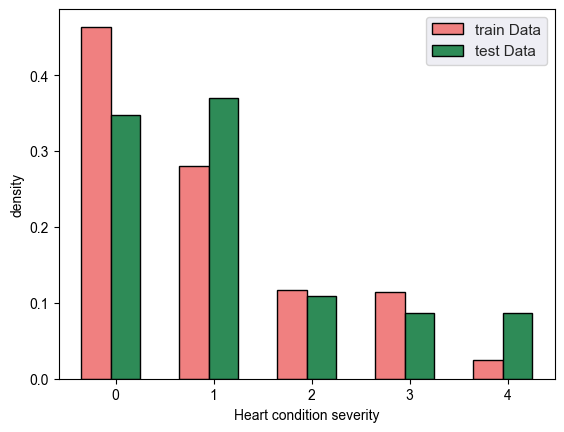

In [9]:

# 1a) creating a barchart using severity data
fig, ax = plt.subplots()
sns.set_theme()
bins = np.arange(6)
counts_train, _ = np.histogram(y_train_nn, bins=bins)
counts_test, _ = np.histogram(y_test_nn, bins=bins)

ax.bar(bins[:-1]-0.2,counts_train/(len(y_train_nn)),alpha=1,color="lightcoral",label="train Data", edgecolor='black',width=0.3)
ax.bar(bins[:-1]+0.1,counts_test/(len(y_test_nn)),alpha=1,color="seagreen",label="test Data", edgecolor='black',width=0.3)

ax.legend()
ax.set_ylabel("density")
ax.set_xlabel("Heart condition severity")
plt.savefig("4a_barchart.png",format="png")



#### Binary Classifier: 3D and 2D Feature Visualization
Select three features.

heart condition (0, 1, 2) ^
healthy heart (0, 1, 2) d


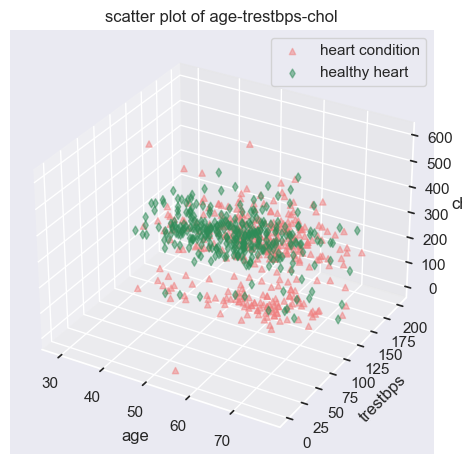

heart condition (0, 1, 3) ^
healthy heart (0, 1, 3) d


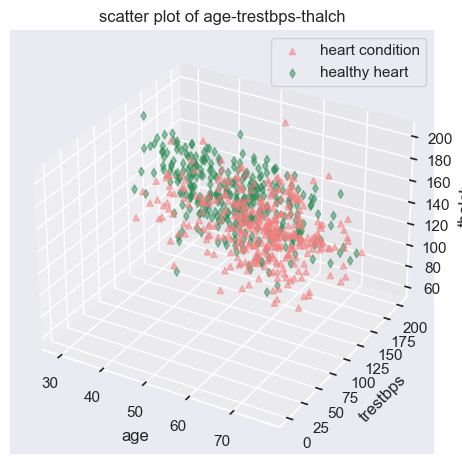

heart condition (0, 2, 3) ^
healthy heart (0, 2, 3) d


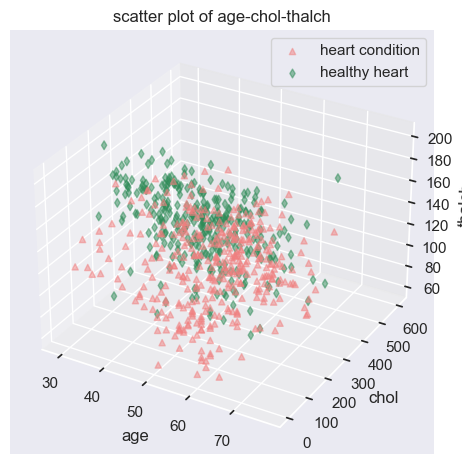

heart condition (1, 2, 3) ^
healthy heart (1, 2, 3) d


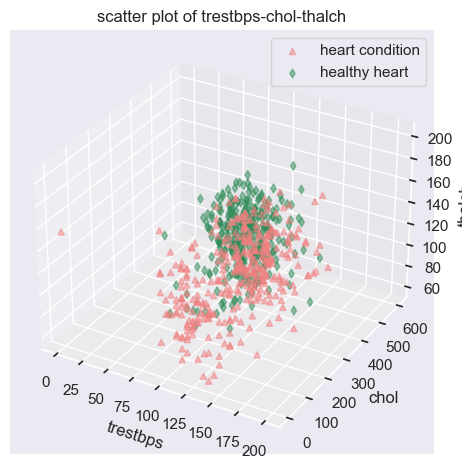

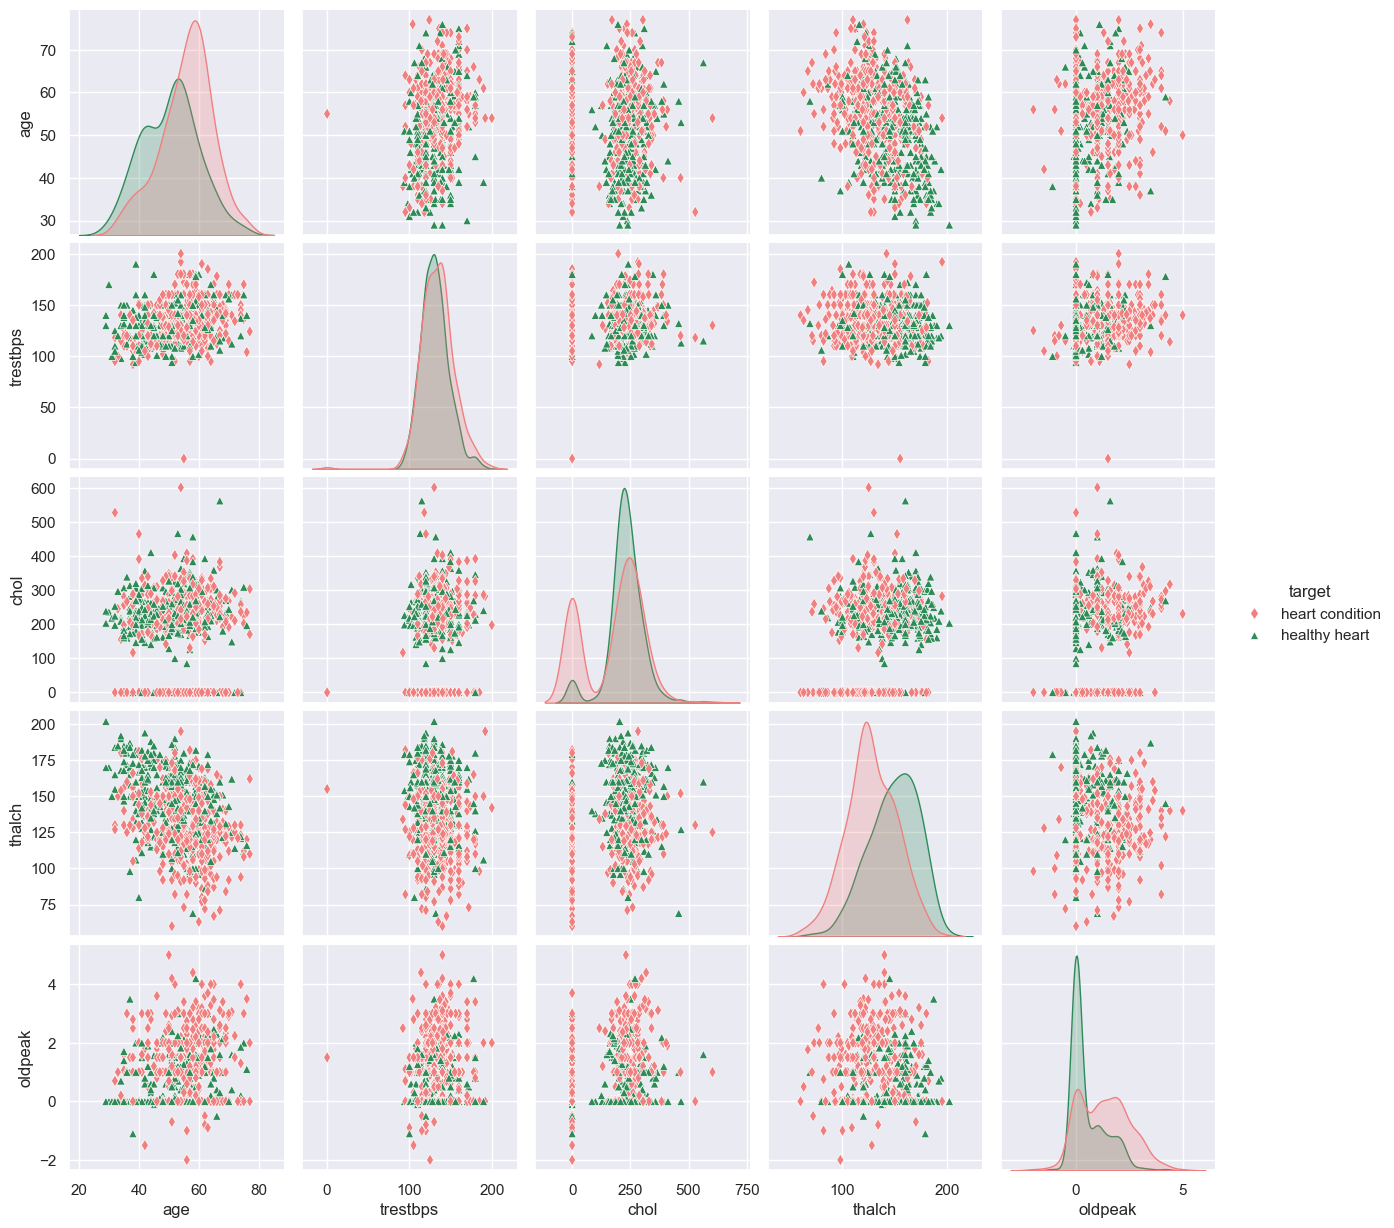

In [10]:

# the selected features 
selected_features = ["age", "chol","thalch"]

#temp df with numeric features and binary target for 3d scatter plots 
df_bin_target = pd.DataFrame(x_train[:,:5],columns=numeric_features)
df_bin_target["target"] = y_train_bin


# plot all different combinations for 3d plots and a pairplot from numeric features
combinations = list(it.combinations(range(4), 3))
for c in combinations: # c for combination
    
    fig = plt.figure()
  
    ax = fig.add_subplot(projection='3d')
    for value ,m ,color in [["heart condition","^","lightcoral"],["healthy heart","d","seagreen"]]:
        print(value,c,m)
        df_tmp  = df_bin_target[df_bin_target["target"]==value]

        x = df_tmp[columns[c[0]]]
        y = df_tmp[columns[c[1]]]
        z = df_tmp[columns[c[2]]]
        # print(df_tmp)
        ax.scatter(x, y, z, marker=m,c=color,label=value,alpha=0.5)
       
        ax.set_xlabel(columns[c[0]])
        ax.set_ylabel(columns[c[1]])
        ax.set_zlabel(columns[c[2]])
        ax.legend()
    ax.set_title("scatter plot of %s-%s-%s"% (columns[c[0]], columns[c[1]],columns[c[2]]))
    plt.tight_layout()
    if [columns[c[0]], columns[c[1]],columns[c[2]]] == selected_features :
        plt.savefig("3d-scatter-of-%s-%s-%s.png"%(columns[c[0]], columns[c[1]],columns[c[2]]),format="png")
    plt.show()

sns.set_palette(sns.color_palette(["lightcoral","seagreen"]))
sns.pairplot(data=df_bin_target,hue="target",hue_order=["heart condition","healthy heart"],markers=["^","d"])
plt.savefig("4b_pairplot.png",format="png")





### Grid search for configuration
Train binary classifiers using only the three selected features as descriptive features.

For this question, we recommend taking a look at the method "cv_results" of the grid search object: https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV

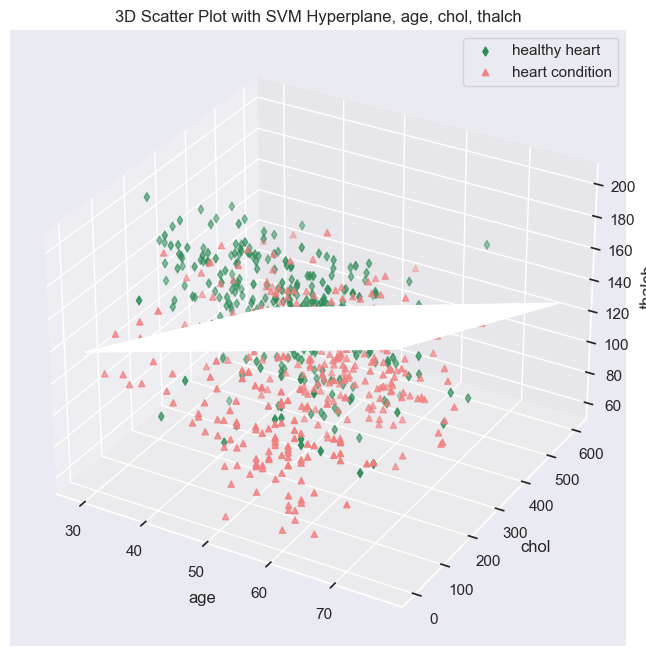

                 precision    recall  f1-score   support

  healthy heart       0.75      0.56      0.64        16
heart condition       0.79      0.90      0.84        30

       accuracy                           0.78        46
      macro avg       0.77      0.73      0.74        46
   weighted avg       0.78      0.78      0.77        46

0.782608695652174
0.7941176470588235


In [11]:



'''4c build svm baseline classifier with fixed vars from question'''

   
#special dfs
x_test_selected = df_test_feature[selected_features[:]]
x_train_selected = df_train_feature[selected_features[:]]


#build classifier
svm_classifier = SVC(C=10, kernel='linear', gamma = 'auto')
svm_classifier.fit(x_train_selected, y_train_bin)


#3d hyperplane plot for baseline classifier
colors ={"heart condition":"lightcoral","healthy heart":"seagreen"}
markers = {"heart condition":"^","healthy heart":"d"}
plot_3d_hyperplane(svm_classifier,df_bin_target[selected_features+target],"target",colors,markers,name="4c")




#evaluation
predict_lin_3f = svm_classifier.predict(x_test_selected)
print(classification_report(y_test_bin, predict_lin_3f))
print(accuracy_score(y_test_bin, predict_lin_3f))
print(precision_score(y_test_bin, predict_lin_3f,pos_label='heart condition'))




Fitting 5 folds for each of 15 candidates, totalling 75 fits


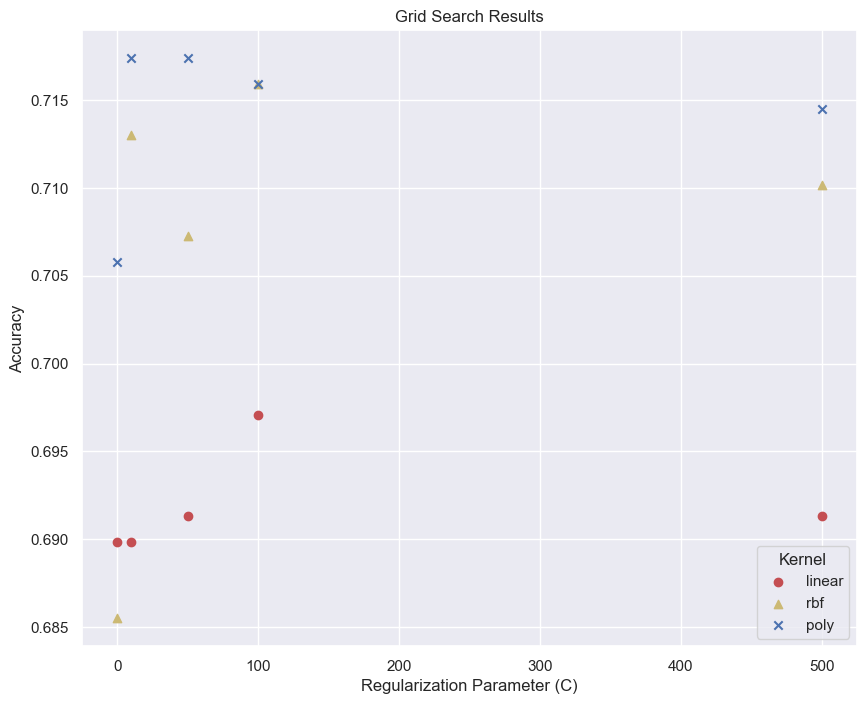

In [12]:

#grid search

grid_params_selected_features = {
    "C": [0.1, 10, 50, 100, 500],
    "kernel": ["linear", "rbf", "poly"],

}

grid = GridSearchCV(SVC(), grid_params_selected_features,scoring= 'accuracy', cv=5, verbose = 3,n_jobs=5)
fit = grid.fit(x_train_selected,y_train_bin)

compare_results_grid_search(grid,"4d_gridsearch")


In [13]:
# validation on test data for each kernel
best_params = grid.best_params_

best_params_kernel = pd.DataFrame()
results = pd.DataFrame(grid.cv_results_)

for kernel in results["param_kernel"].unique():
    kernel_data = results[results["param_kernel"] == kernel]
    index = kernel_data["mean_test_score"].idxmax()
    test = [kernel_data["param_C"][index], kernel_data["mean_test_score"][index]]
    print("best performing params for %s"%kernel, kernel_data["param_C"][index], kernel_data["mean_test_score"][index])
    # best_params_kernel[kernel] = test

    svm_classifier = SVC(C=kernel_data["param_C"][index], kernel=kernel)
    fit = svm_classifier.fit(x_train_selected,y_train_bin)
    predict = svm_classifier.predict(x_test_selected)
    
    print(kernel,":",accuracy_score(y_test_bin,predict),classification_report(y_test_bin,predict))





best performing params for linear 100.0 0.6971014492753623
linear : 0.782608695652174                  precision    recall  f1-score   support

  healthy heart       0.71      0.62      0.67        16
heart condition       0.81      0.87      0.84        30

       accuracy                           0.78        46
      macro avg       0.76      0.75      0.75        46
   weighted avg       0.78      0.78      0.78        46

best performing params for rbf 100.0 0.7159420289855072
rbf : 0.782608695652174                  precision    recall  f1-score   support

  healthy heart       0.67      0.75      0.71        16
heart condition       0.86      0.80      0.83        30

       accuracy                           0.78        46
      macro avg       0.76      0.78      0.77        46
   weighted avg       0.79      0.78      0.79        46

best performing params for poly 10.0 0.717391304347826
poly : 0.7608695652173914                  precision    recall  f1-score   support

  hea

### Baseline Models
Both classifier types are trained using all features.

#### SVMs: Base Binary Classifier

                 precision    recall  f1-score   support

  healthy heart       0.88      0.94      0.91        16
heart condition       0.97      0.93      0.95        30

       accuracy                           0.93        46
      macro avg       0.92      0.94      0.93        46
   weighted avg       0.94      0.93      0.94        46



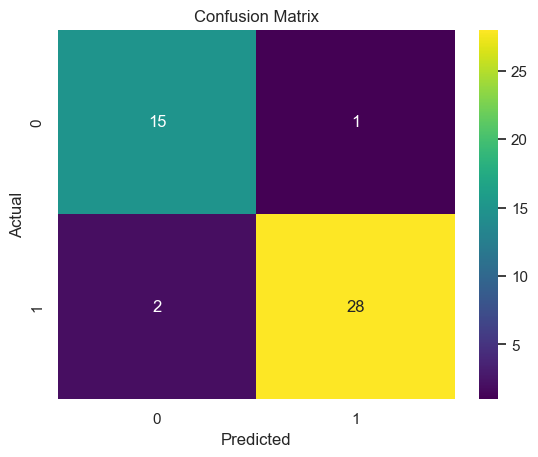

In [14]:

# baseline classifier
svm_baseline = SVC(C=10, kernel="linear")
fit_base = svm_baseline.fit(x_train,y_train_bin)
predict_base = svm_baseline.predict(x_test)

# confusion matrix and report 
print(classification_report(y_test_bin,predict_base))
conf_base =  confusion_matrix(y_test_bin,predict_base)
sns.heatmap(conf_base, annot=True, fmt='d', cmap='viridis')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.savefig("4f_SVM-Baseline.png")
plt.show()


#### Neural Network: Base Classifier

c:\Users\finnv\envs\uni\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\finnv\envs\uni\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\finnv\envs\uni\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.46      1.00      0.63       320
           1       0.00      0.00      0.00       193
           2       0.00      0.00      0.00        81
           3       0.00      0.00      0.00        79
           4       0.00      0.00      0.00        17

    accuracy                           0.46       690
   macro avg       0.09      0.20      0.13       690
weighted avg       0.22      0.46      0.29       690



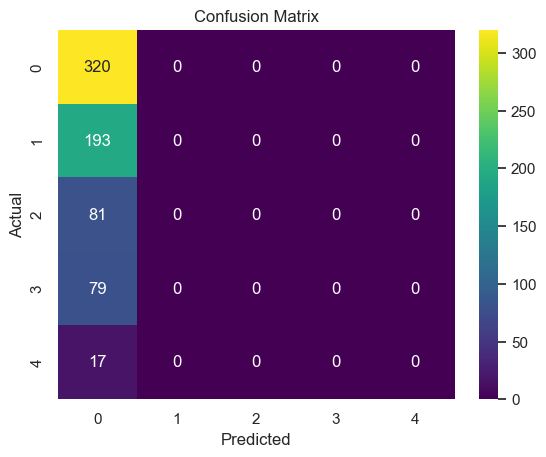

In [15]:

#baseline MLP classifier with 5 layers and 5 neurons per layer. 
layers = (5,5,5,5,5,)
nn_classifier = MLPClassifier(hidden_layer_sizes=layers,max_iter=5000,activation="logistic")

nn_fit = nn_classifier.fit(x_train, y_train_nn)
nn_pred = nn_classifier.predict(x_train)

#  confusion matrix and report
print(classification_report(y_train_nn,nn_pred))
conf_nn =  confusion_matrix(y_train_nn,nn_pred)

### this confusion matrix is sus #### 

sns.heatmap(conf_nn, annot=True, fmt='d', cmap='viridis')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.savefig("4g_confusionMatrix.png")
plt.show()


### Feature Engineering

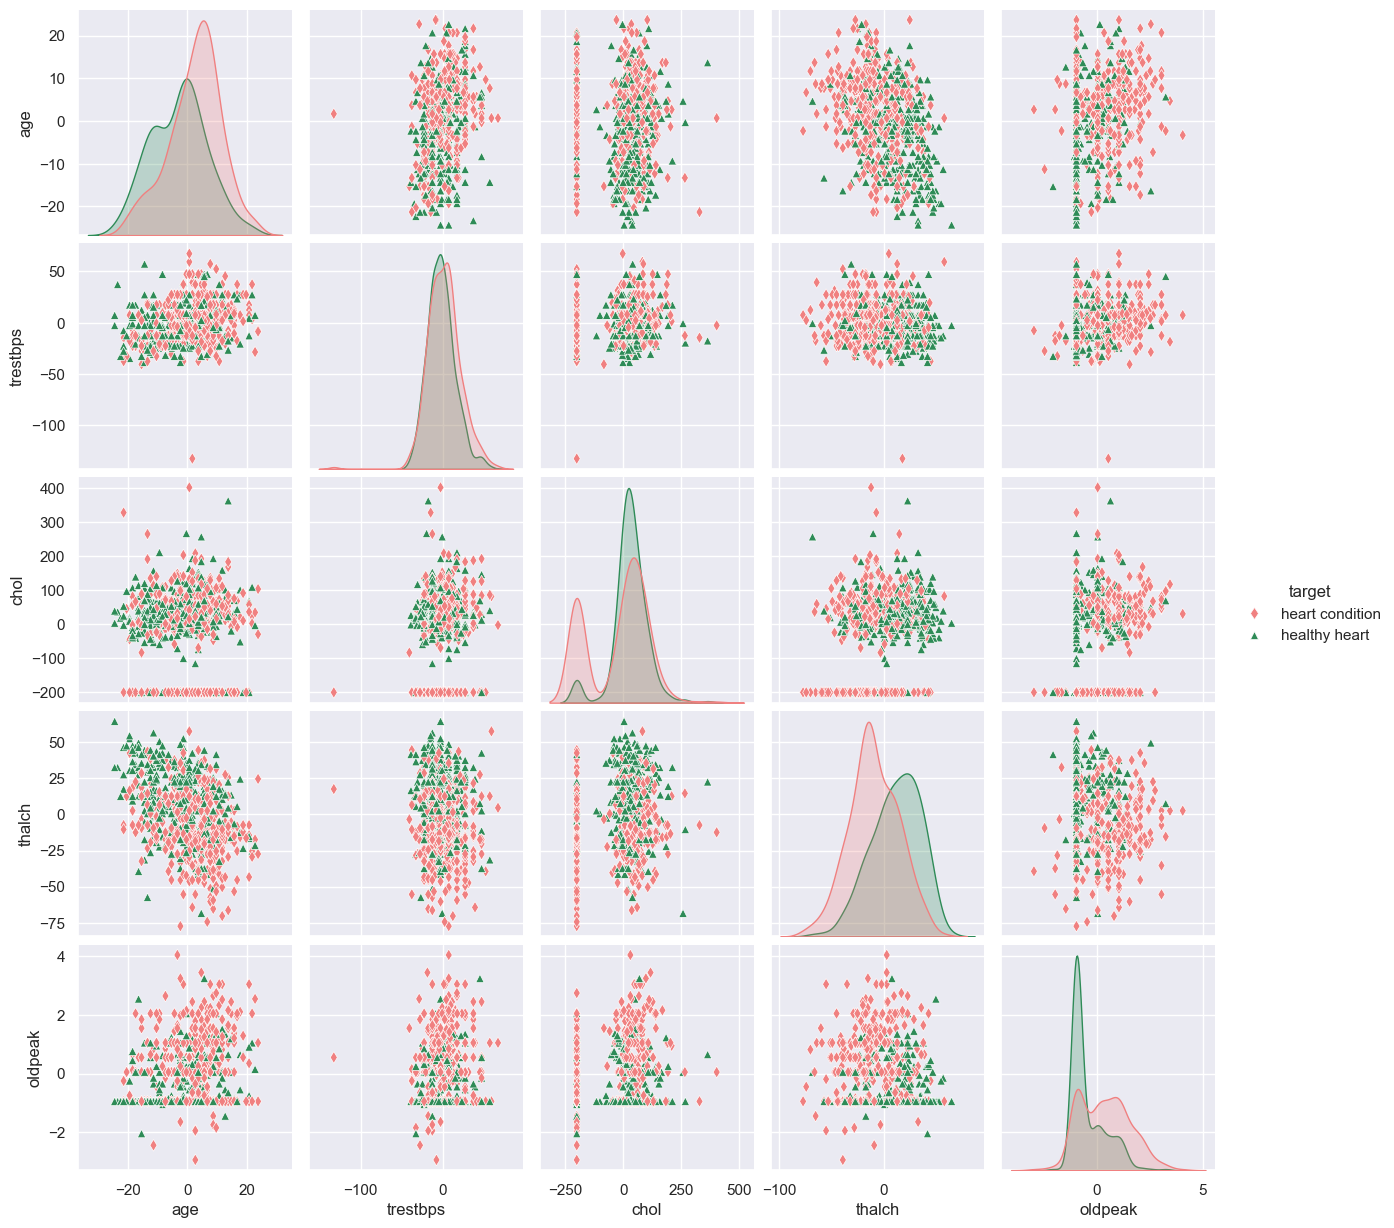

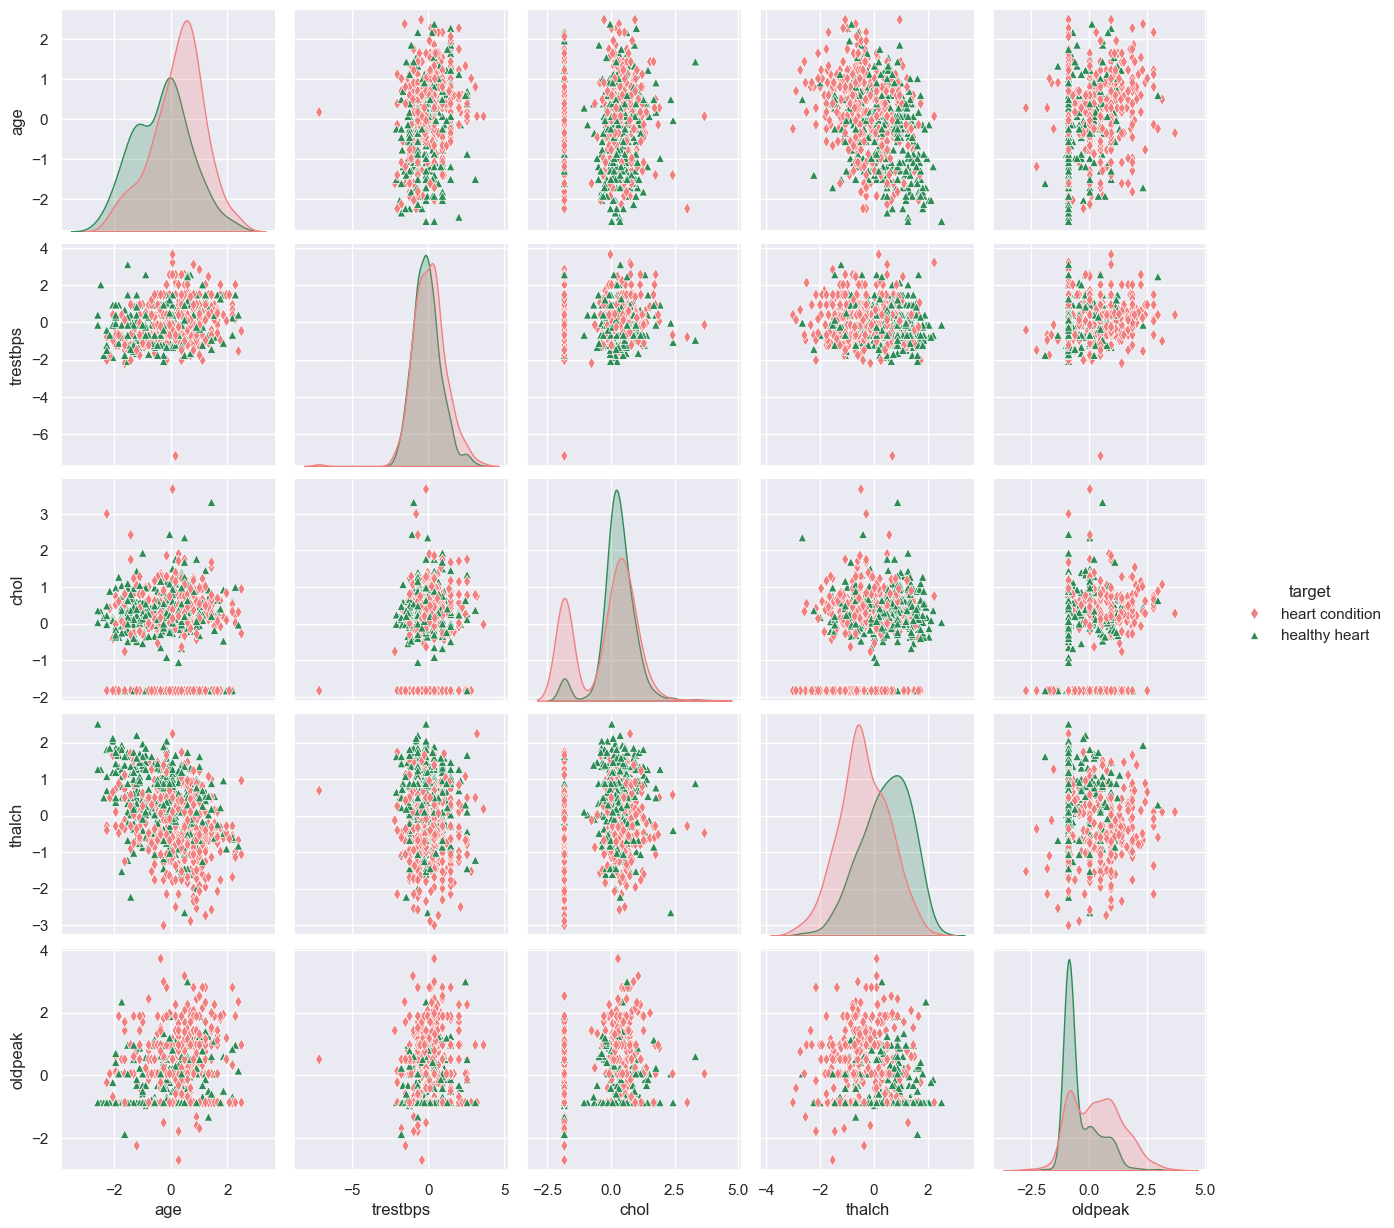

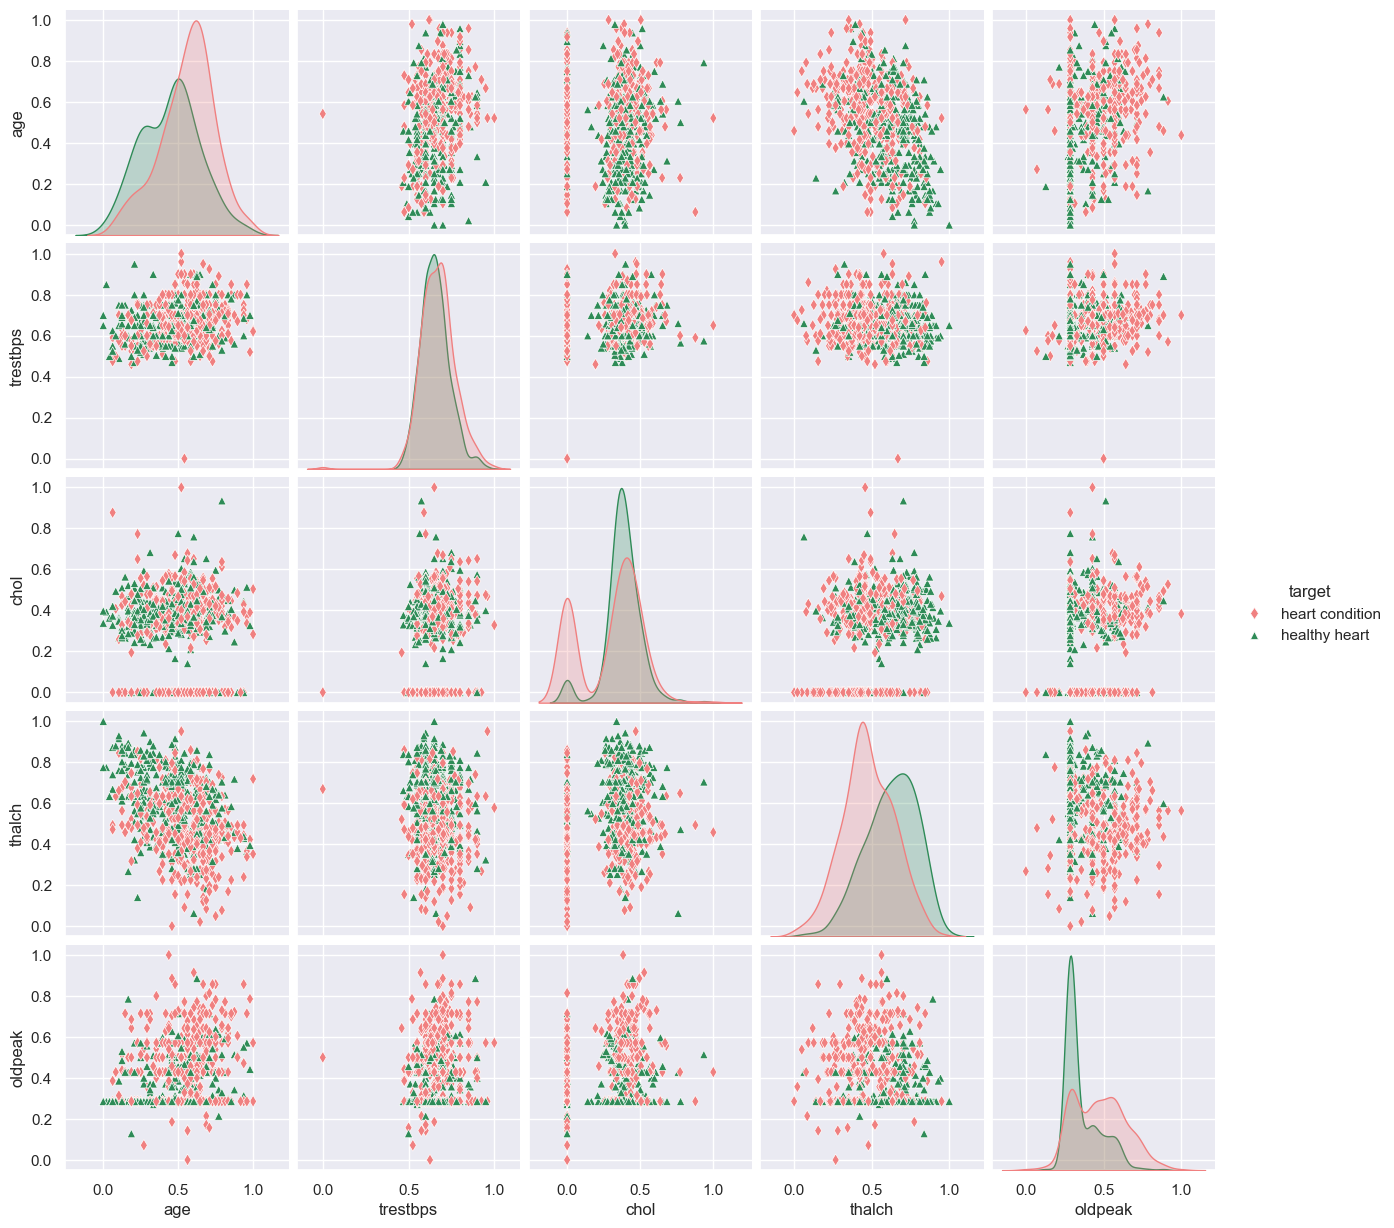

In [16]:


def deviation_mean(training_data: pd.DataFrame, test_data: pd.DataFrame, features_to_transform: list = None,
                   target_name: str = target_name) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Pass training and test data as well as a list of features you want to transform. Function returns test and training data lifted to the higher dimension by dividing each of the passed feature names' values by the trainings data's mean."""

    if features_to_transform is None:
        features_to_transform = training_data.columns.drop(target_name)
    
    training_data_transformed = training_data.copy()
    test_data_transformed = test_data.copy()


    # for each column compute mean and subtract it from every entry in that column
    for feature  in features_to_transform:
        mean_train = np.mean(training_data_transformed[feature])
        training_data_transformed[feature] = training_data_transformed[feature] - mean_train

        mean_test = np.mean(test_data_transformed[feature])
        test_data_transformed[feature] = test_data_transformed[feature] - mean_test
    
    return training_data_transformed, test_data_transformed


def scale_zero(training_data: pd.DataFrame, test_data: pd.DataFrame, features_to_transform: list = None,
               target_name: str = target_name) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Pass training data and test data as well as a list of features you want to transform. Function returns dataframes containing the transformed test and training data. In the transformed dataframes the values of each of the passed feature names are scaled around zero."""
    if features_to_transform is None:
        features_to_transform = training_data.columns.drop(target_name)
    
    

    training_data_transformed = training_data.copy()
    test_data_transformed = test_data.copy()
    scaler = StandardScaler()
    # for each column compute mean and subtract it from every entry in that column
    for feature  in features_to_transform:

        training_data_transformed[feature] = scaler.fit_transform(training_data[[feature]])
        test_data_transformed[feature] = scaler.fit_transform(test_data[[feature]])
   

    

    return training_data_transformed, test_data_transformed


def normalize_features(training_data: pd.DataFrame, test_data: pd.DataFrame, features_to_transform: list = None,
                       target_name: str = target_name) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Pass training data and test data as well as a list of features you want to transform. Function returns dataframes containing the transformed test and training data. In the transformed dataframes the values of each of the passed features are normalized according to the value's ranges."""

    if features_to_transform is None:
        features_to_transform = training_data.columns.drop(target_name)

    ## setup
    training_data_transformed = training_data.copy()
    test_data_transformed = test_data.copy()
    scaler = MinMaxScaler()
    # for each column compute mean and subtract it from every entry in that column
    for feature  in features_to_transform:

        training_data_transformed[feature] = scaler.fit_transform(training_data[[feature]])
        test_data_transformed[feature] = scaler.fit_transform(test_data[[feature]])
   
    return training_data_transformed, test_data_transformed


# create dataset with all necessary columns, including target for pairplots
df_train_full = df_train_feature.copy()
df_train_full["target"] = df_train_str_target 
df_test_full = df_test_feature.copy()
df_test_full["target"] = df_test_str_target 
features = numeric_features + ["target"] 


#set colorpalett 
sns.set_palette(sns.color_palette(["lightcoral","seagreen"]))
#create three different pairplots for the three different scalings
sns.pairplot(data=deviation_mean(df_train_full,df_test_full,numeric_features,"target")[0][features],hue="target",hue_order=["heart condition","healthy heart"],markers=["^","d"])
plt.savefig("4h_deviation_mean.png")
plt.show()
sns.pairplot(data=scale_zero(df_train_full,df_test_full,numeric_features,"target")[0][features],hue="target",hue_order=["heart condition","healthy heart"],markers=["^","d"])
plt.savefig("4h_scale_zero.png")
plt.show()
sns.pairplot(data=normalize_features(df_train_full,df_test_full,numeric_features,"target")[0][features],hue="target",hue_order=["heart condition","healthy heart"],markers=["^","d"])
plt.savefig("4h_normalize_features.png")
plt.show()



In [17]:
x_train_scaled_norm = deviation_mean(df_train,df_test,numeric_features,"num")[0]
x_test_scaled_norm = normalize_features(df_train,df_test,numeric_features,"num")[1]

# x_train_scaled_norm.drop("num",axis='columns')
# print(x_train_scaled_norm)
# x_train_scaled_norm=x_train_scaled_norm.to_numpy(dtype=np.float64)


### Neural Network Structure
First, only consider the training data. Then, in the next subtask, consider the test data as well.

True


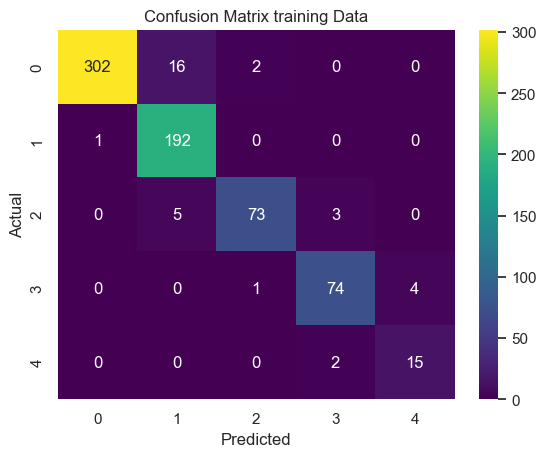

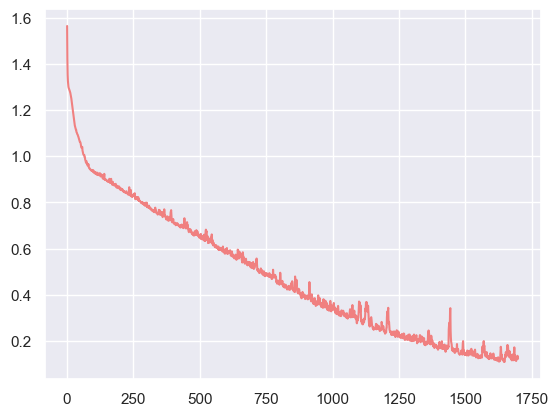

True


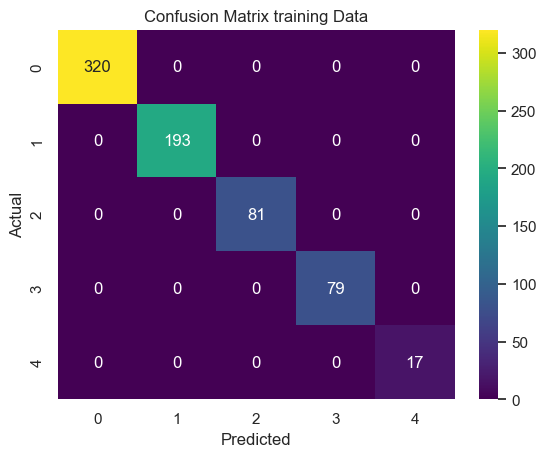

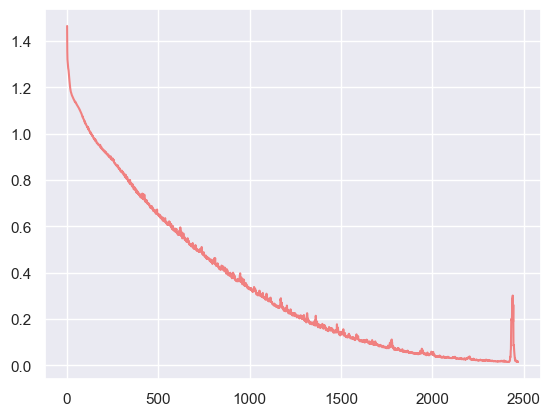

True


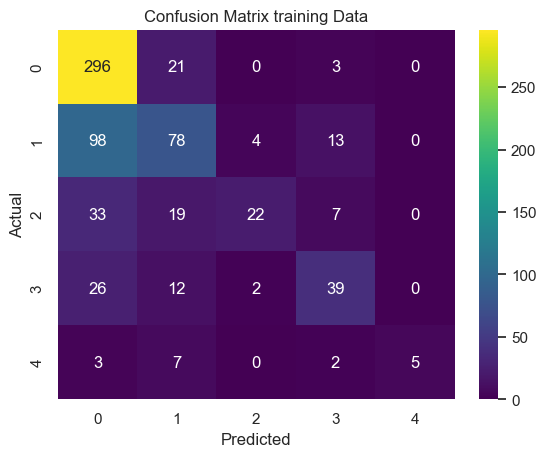

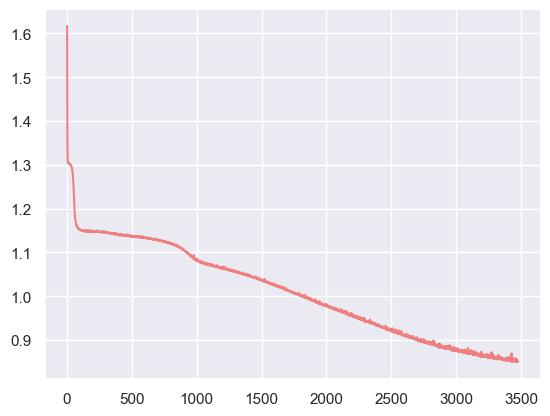

False


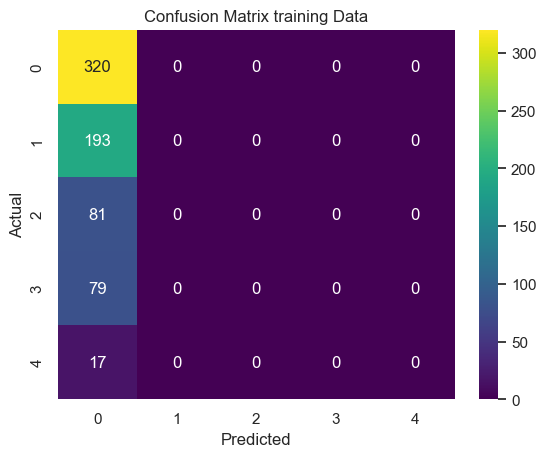

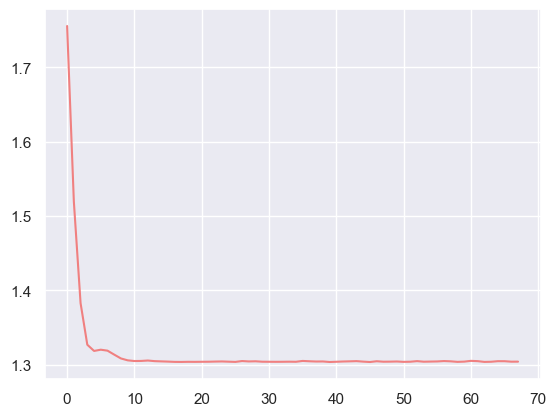

In [ ]:
def nn_stuff(x_train,x_test,y_train,y_test):
    '''to minimize code redundance this function trains and validates the data and creates a confusion matrix  '''
    
    try:
        x_train = x_train.to_numpy(dtype=np.int64)
        x_test = x_test.to_numpy(dtype=np.int64)
    except: 
        print("no")


    '''grid search to find a working example for a more complex nn that guesses every severity at least once'''
    # numbers = np.linspace(6,100,95)
    # print(numbers)
    # lengths = [3,4,5,6,7,8,9,10]
    # # print(x_train,x_test)
    # layer = [(int(number),) * length for length in lengths for number in numbers]
    # nn_params = {"hidden_layer_sizes":layer}
                
                 
    # grid_nn = GridSearchCV(MLPClassifier(activation="logistic",max_iter=5000,n_iter_no_change=50),nn_params,scoring= 'accuracy', cv=2, verbose = 3,n_jobs=-1)
    # fit = grid_nn.fit(x_train, y_train)
    # print(grid_nn.best_params_)
    # classifier that should be better than the baseline classifier. currently it has only 2 layers with 10 neurons as this seems to work, oposing to the propsed 
    # more complex network from the exercise????#
   
    #build more complex classifier
    layers = (90,90,90)
  
    nn_classifier_scaled = MLPClassifier(hidden_layer_sizes=layers,activation='logistic',max_iter=5000,n_iter_no_change=50)
    nn_fit = nn_classifier_scaled.fit(x_train, y_train)
    nn_pred_scaled = nn_classifier_scaled.predict(x_train)
    

    
    # confusion matrix for the training dataset
    conf_nn =  confusion_matrix(y_train,nn_pred_scaled)
    test = ((conf_nn > 0).any(axis=0) ==True).all()
    print(test)
    if True: 
        
        sns.heatmap(conf_nn, annot=True, fmt='d', cmap='viridis')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.title('Confusion Matrix training Data')
        plt.show()
        
    # quick plot to show loss curve for debugging
    plt.plot(range(0,len(nn_fit.loss_curve_)),nn_fit.loss_curve_)

    plt.show()
    # confusion matrix
    

#compute for the original data and the normalized data
nn_stuff(df_train_feature,df_test_feature,y_train_nn,y_test_nn)
nn_stuff(deviation_mean(df_train,df_test,numeric_features,"num")[0][numeric_features],deviation_mean(df_train,df_test,numeric_features,"num")[1][numeric_features],y_train_nn,y_test_nn)
nn_stuff(scale_zero(df_train,df_test,numeric_features,"num")[0][numeric_features],scale_zero(df_train,df_test,numeric_features,"num")[1][numeric_features],y_train_nn,y_test_nn)
nn_stuff(normalize_features(df_train,df_test,numeric_features,"num")[0][numeric_features],normalize_features(df_train,df_test,numeric_features,"num")[1][numeric_features],y_train_nn,y_test_nn)

### Good SVM Classifier
Perform some educated trial and error to try and find a good SVM classifier.

In [171]:
# test =[deviation_mean(df_train,df_test,numeric_features,"num"),normalize_features(df_train,df_test,numeric_features,"num"),scale_zero(df_train,df_test,numeric_features,"num")]

# for x in test:
#     x_train_good = x[0][columns[:-1]]
#     # x_train_good.drop("num",axis="column")

#     print(columns[:-1])
#     x_test_good = x[1][columns[:-1]]

#     svm_good = SVC()



#     grid_params_selected_features = {
#         "C": [0.1,10,100],
#         "kernel": ["linear"]

#     }

#     grid = GridSearchCV(svm_good, grid_params_selected_features,scoring= 'accuracy', cv=3, verbose = 3,n_jobs=10)

#     grid.fit(x_train_good,y_train_bin)


#     compare_results_grid_search(grid,"grid search") 

#     best_model = grid.best_estimator_

#     y_pred = best_model.predict(x_test_good)
#     test_accuracy = classification_report(y_test_bin, y_pred)
#     print(test_accuracy)